In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time
import datetime
import itertools
from collections import defaultdict
from functools import reduce

#  “Broder et al” butterfly picture of the directed network

In [2]:
directed_graph = "web-Stanford.txt"
undirected_graph = "email-Enron.txt"

In [3]:
G = defaultdict(set)
# Load data into the graph data structure
with open(directed_graph, "r") as ins:
    for line in ins:
        if not line.startswith("#"):
            u, v = [int(i) for i in line.split()]
            G[u].add(v)

In [4]:
# Compute SCC
def scc(G):
    """
    Run Depth First Search to find out the finish times 
    to find each vertex in graph G.
    Pass the visited set in case we have a disconnected graph
    """
    visited, finish_times = set(), []
    for u in list(G.keys()):
        if u not in visited:
            finish_times.extend([v for v in dfs(G, u, visited)])
    
    # Reverse graph G
    GR = defaultdict(set)
    for u, nodes in G.items():
        for v in nodes:
            GR[v].add(u)
    
    """
    Compute strongly connected components by running Depth First Search
    on a reversed graph G, by exploring in reversed finish_times order.
    Pass the visited set to no explore the same components multiple times
    """
    visited, scc = set(), defaultdict(set)
    for u in reversed(finish_times):
        if u not in visited:
            scc[u].update([node for node in dfs(GR, u, visited)])
    return scc

# Run iterative DFS to prevent stack overflow in large graphs
def dfs(G, source, visited):
    stack, popped = [source], set()
    while stack:
        node = stack[-1]
        to_visit = G[node] - visited
        if node not in visited:
            visited.add(node)
            stack.extend(to_visit)
        else:
            stack.pop()
            if node not in popped:
                popped.add(node)
                yield node

In [5]:
s = time.perf_counter()
components = sorted(scc(G).values(), key=len)
# largest SCC
giant = components[-1]
# nodes not in largest SCC
not_giant = reduce(set.union, components[:-1])
print("SCC computation time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

SCC computation time: 0:00:16


In [6]:
in_nodes = 0
for u in not_giant:
    if G[u].intersection(giant):
        in_nodes += 1

In [7]:
out_nodes = 0
for u in giant:
    if G[u].intersection(not_giant):
        out_nodes += 1

In [8]:
print("Nodes in the giant SCC: {}".format(len(giant)))
print("Nodes in the IN section of the graph: {}".format(in_nodes))
print("Nodes in the OUT section of the grap: {}".format(out_nodes))

Nodes in the giant SCC: 150532
Nodes in the IN section of the graph: 26239
Nodes in the OUT section of the grap: 2604


# Graphs

In [9]:
D = nx.read_edgelist(directed_graph, create_using=nx.DiGraph(), nodetype=int)
G = nx.read_edgelist(undirected_graph, create_using=nx.Graph(), nodetype=int)

In [10]:
def avg_shortest_path(G, N):
    visited = set()
    nodes = list(G.nodes())
    np.random.seed(123)
    np.random.shuffle(nodes)
    avg = []
    for n in range(N):
        node = nodes[n]
        visited.add(node)
        lengths = []
        for s, l in nx.single_source_shortest_path_length(G,node).items():
            if s != node and G.is_directed() is True or s not in visited:
                lengths.append(l)
        avg.append(np.mean(lengths))
    return np.mean(avg)

In [11]:
def gen_ccdf(degrees):
    hist = {}
    c = 0
    if min([d for _, d in degrees]) == 0:
        c = 1    
    for d in [d+c for _, d in degrees]:
        hist[d] = hist.get(d,0) + 1

    cumsum = 0
    ccdf = {}
    for d in sorted(hist.keys(), reverse=True):
        cumsum += hist[d]
        ccdf[d] = cumsum/len(degrees)
    x,y = zip(*(ccdf.items()))
    return np.array(x), np.array(y)
        
def plot_ccdf(x, y, fit_coeffs, title):
    plt.loglog(x,y)
    x1 = sorted(x)
    poly = np.poly1d(fit_coeffs)
    yfit = lambda x: np.exp(poly(np.log(x)))
    plt.loglog(x1,yfit(x1),"--",color="r")
    plt.ylim(1e-6)
    plt.xlabel("in-degree ($d$)")
    plt.ylabel("$P(D_v > d)$")
    plt.title(title)

def fit_ccdf(x, y):
    return np.polyfit(np.log(x), np.log(y), 1)

1.0704116161096786 2.070411616109679


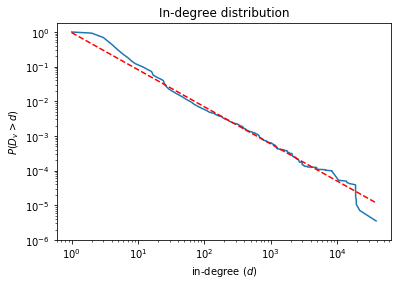

In [12]:
x, y = gen_ccdf(D.in_degree())
coeffs = fit_ccdf(x,y)
plot_ccdf(x, y, coeffs, "In-degree distribution")
D_beta = -coeffs[0]
D_alpha = D_beta+1
print(D_beta, D_alpha)

In [13]:
s = time.perf_counter()
D_assortativity = nx.degree_pearson_correlation_coefficient(D)
D_clustering = nx.average_clustering(D)
D_shortest_path = nx.average_shortest_path_length(D)
print("Degree Assortativity Coefficient:\t{}".format(D_assortativity))
print("Clustering Coefficient:\t\t\t{}".format(D_clustering))
print("Average path length (sampled):\t\t{}".format(D_shortest_path))

print("Computation time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))

NetworkXError: Graph is not weakly connected.

In [ ]:
x, y = gen_ccdf(G.degree())
coeffs = fit_ccdf(x,y)
G_beta = -coeffs[0]
G_alpha = G_beta+1
plot_ccdf(x, y, coeffs, "Degree distribution")
print(G_beta, G_alpha)

In [ ]:
s = time.perf_counter()
G_assortativity = nx.degree_pearson_correlation_coefficient(G)
G_clustering = nx.average_clustering(G)
D_shortest_path = nx.average_shortest_path_length(G)
print("Degree Assortativity Coefficient:\t{}".format(G_assortativity))
print("Clustering Coefficient:\t\t\t{}".format(G_clustering))
print("Average path length (sampled):\t\t{}".format(D_shortest_path))

print("Computation time: {}".format(datetime.timedelta(seconds=int(time.perf_counter()-s))))